# Aligning HST images to an absolute reference catalog
***

<div class="alert-danger">Note: The notebook in this repository 'Initializtion.ipynb' goes over many of the basic concepts such as the setup of the environment/package installation and should be read first if you are new to HST images, 'DrizzlePac' or 'Astroquery'.</div>

<div class="alert-warning">Note: This notebook is based on WFC3 ISR 2017-19: <a href="http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2017-19.pdf">Aligning HST Images to Gaia: a Faster Mosaicking Workflow</a> and contains a subset of the information/code found in <a href="https://github.com/spacetelescope/gaia_alignment">the repository here</a>.  For more information, see the notebook in that repository titled 'Gaia_alignment.ipynb'.</div>

## Introduction

The alignment of HST exposures is a critical step in image stacking/combination performed by software such as `AstroDrizzle`.  Generally, a relative alignment is performed that aligns one image (or multiple images) to another image which is designated as the reference image.  This makes it so the images are aligned to each other, but the pointing error of the observatory can still cause the images to have incorrect absolute astrometry.

When absolute astrometry is desired, the images can be aligned to an external catalog that is known to be on an absolute frame.  In this example, we will provide a workflow to query catalogs such as SDSS and Gaia via the astroquery package, and then align the images to that catalog via TweakReg.

For more information about TweakReg, see the other notebooks in this repository or the __[TweakReg Documentation](https://drizzlepac.readthedocs.io/en/deployment/tweakreg.html)__.

For more information on Astroquery, see the other notebooks in this repository or the __[Astroquery Documentation](https://astroquery.readthedocs.io/en/latest/)__.

In [2]:
import astropy.units as u
import glob
import numpy as np
import matplotlib.pyplot as plt
import os

from astropy.io import fits
from astropy.table import Table
from astropy.units import Quantity
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astroquery.mast import Observations
from astroquery.sdss import SDSS

#from ccdproc import ImageFileCollection
from IPython.display import Image

from drizzlepac import tweakreg
from drizzlepac import astrodrizzle

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


# 1. Set up the data

In [6]:
from utils import header_utils as hutils

In [19]:
from pathlib import Path
Path("/user/jaguilar/tr14/code/utils/header_utils.py").parent / "../../data/tables/"

PosixPath('/user/jaguilar/tr14/code/utils/../../data/tables')

In [20]:
from importlib import reload
reload(hutils)

<module 'utils.header_utils' from '/user/jaguilar/tr14/code/utils/header_utils.py'>

In [21]:
prihdrs = hutils.load_headers('pri')
scihdrs = hutils.load_headers('sci')

In [25]:
# TH.print_columns(prihdrs)
gb_filter = prihdrs.groupby('filter')
gb_filter

In [ ]:
TH.print_columns(prihdrs)

In [26]:
# re-download the data from MAST, following the example
proposids = prihdrs['proposid'].unique()
filters = prihdrs['filter'].unique()
prihdrs.query(f"proposid == {proposids[0]}")

,simple,bitpix,naxis,extend,origin,date,nextend,filename,filetype,telescop,...,flshfile,pctetab,snkcfile,upwcsver,pywcsver,npolfile,idctab,d2imfile,sipname,distname
0,True,16,0,True,HSTIO/CFITSIO March 2010,2019-12-30,13,icct01i5q_flt.fits,SCI,HST,...,NaN,NaN,NaN,1.4.0,3.0.4,NaN,iref$w3m18525i_idc.fits,NaN,icct01i5q_w3m18525i,icct01i5q_w3m18525i-NOMODEL-NOMODEL
3,True,16,0,True,HSTIO/CFITSIO March 2010,2019-12-30,13,icct02jxq_flt.fits,SCI,HST,...,NaN,NaN,NaN,1.4.0,3.0.4,NaN,iref$w3m18525i_idc.fits,NaN,icct02jxq_w3m18525i,icct02jxq_w3m18525i-NOMODEL-NOMODEL
4,True,16,0,True,HSTIO/CFITSIO March 2010,2019-12-30,14,icct04omq_flt.fits,SCI,HST,...,NaN,NaN,NaN,1.4.0,3.0.4,NaN,iref$w3m18525i_idc.fits,NaN,icct04omq_w3m18525i,icct04omq_w3m18525i-NOMODEL-NOMODEL
5,True,16,0,True,HSTIO/CFITSIO March 2010,2019-12-30,13,icct04p1q_flt.fits,SCI,HST,...,NaN,NaN,NaN,1.4.0,3.0.4,NaN,iref$w3m18525i_idc.fits,NaN,icct04p1q_w3m18525i,icct04p1q_w3m18525i-NOMODEL-NOMODEL
6,True,16,0,True,HSTIO/CFITSIO March 2010,2019-12-30,14,icct02jiq_flt.fits,SCI,HST,...,NaN,NaN,NaN,1.4.0,3.0.4,NaN,iref$w3m18525i_idc.fits,NaN,icct02jiq_w3m18525i,icct02jiq_w3m18525i-NOMODEL-NOMODEL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,True,16,0,True,HSTIO/CFITSIO March 2010,2019-12-30,13,icct04oxq_flt.fits,SCI,HST,...,NaN,NaN,NaN,1.4.0,3.0.4,NaN,iref$w3m18525i_idc.fits,NaN,icct04oxq_w3m18525i,icct04oxq_w3m18525i-NOMODEL-NOMODEL
178,True,16,0,True,HSTIO/CFITSIO March 2010,2019-12-30,13,icct04p0q_flt.fits,SCI,HST,...,NaN,NaN,NaN,1.4.0,3.0.4,NaN,iref$w3m18525i_idc.fits,NaN,icct04p0q_w3m18525i,icct04p0q_w3m18525i-NOMODEL-NOMODEL
179,True,16,0,True,HSTIO/CFITSIO March 2010,2019-12-30,13,icct01iaq_flt.fits,SCI,HST,...,NaN,NaN,NaN,1.4.0,3.0.4,NaN,iref$w3m18525i_idc.fits,NaN,icct01iaq_w3m18525i,icct01iaq_w3m18525i-NOMODEL-NOMODEL
180,True,16,0,True,HSTIO/CFITSIO March 2010,2019-12-30,13,icct04p7q_flt.fits,SCI,HST,...,NaN,NaN,NaN,1.4.0,3.0.4,NaN,iref$w3m18525i_idc.fits,NaN,icct04p7q_w3m18525i,icct04p7q_w3m18525i-NOMODEL-NOMODEL


### Inspect the image header

The cell below shows how to query information from the image header using `ImageFileCollection` in `ccdproc`. 
We see that the 1st exposure is 30 seconds and the 2nd and 3rd exposures are 360 seconds. The 3rd exposure is dithered by ~82" in the Y-direction which is approximately the width of one UVIS chip. 

# 2. Querying catalogs

Now that we have the images, we will download the reference catalogs from both SDSS and Gaia using `astroquery`.

### 2a. Identify Coordinates
We will first create a SkyCoord Object to point astroquery to where we are looking on the sky.  Since our example uses data from NGC 6791, we will use the `ra_targ` and `dec_targ` keywords from the first image to get the coordinates of the object.

In [29]:
RA, Dec = prihdrs[['ra_targ','dec_targ']].mean()

### 2b. SDSS Query
We now give those values to an astropy `SkyCoord` object, which we will pass to the SDSS.  Additionally, we use an astropy `Quantity` object to create a radius for the SDSS query.  We set the radius to 6 arcminutes to comfortably cover the area of our images. For reference UVIS detector field of view is ~2.7'x2.7' and a y-dither of 82" covers a total area on the sky of ~2.7'x4.1'.

In [31]:
coord = SkyCoord(ra=RA, dec=Dec, unit=(u.deg, u.deg))
radius = Quantity(6., u.arcmin)

Then we only need to perform the query via the `SDSS.query_region` method of `astroquery.sdss`. The `spectro=False` keyword argument means we want to exclude spectroscopic objects, as we are looking for objects to match with an image.  

In the fields parameter, we specify a list of fields we want returned by the query.  In this case we only need the position, and maybe a magnitude 'g' if we want to cut very dim and/or bright objects out of the catalog, as those are likely measured poorly. Details on selecting objects by magnitude may be found in the original ['Gaia_alignment' notebook](https://github.com/spacetelescope/gaia_alignment).  Many other fields are available in the SDSS query and are [documented here](http://cas.sdss.org/dr7/en/help/browser/description.asp?n=PhotoObj&t=V).

### 2c. Gaia Query
Similarly to SDSS, we can query Gaia catalogs for our target via `astroquery.gaia`.  We can use the same `coord` and  `radius` from the SDSS query.

In [32]:
gaia_query = Gaia.query_object_async(coordinate=coord, radius=radius)
gaia_query

INFO: Query finished. [astroquery.utils.tap.core]


solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,dist
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / mas2,1 / um,1 / um,,,,mas,,,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,,deg,deg,deg,deg,,K,K,K,mag,mag,mag,mag,mag,mag,,Rsun,Rsun,Rsun,Lsun,Lsun,Lsun,,,
int64,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,float32,float32,float64,float64,int16,bool,float32,float64,float64,float32,int16,int16,float32,int32,int16,bool,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,float32,int16,float32,float32,float32,float64,float64,int32,float32,float32,float32,object,float64,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,object,object,float64
1635721458409799680,Gaia DR2 5350363807162597120,5350363807162597120,872774637,2015.5,160.97658959010133,0.3365367713567268,-59.55249098182289,0.5359762944092921,0.8733720941089513,0.570336928617211,1.5313265,-7.576554319260021,1.3728263698855137,6.801937455810753,1.4254079927418715,-0.49423218,0.56721884,-0.30539086,0.46292046,-0.7448693,0.49659374,-0.6913826,-0.31673318,0.60329133,-0.76882905,98,0,98,0,8.656539,266.71506,1.5855562472222249,11.415050326483556,31,False,0.24230614,1.3966305627734596,0.08398083392477768,0.14143619,11,7,1.6897193,0,18,False,121,1095.1866439909002,12.487370361394136,87.703545,18.089645,0,--,--,--,--,0,--,--,--,--,--,2,--,--,--,--,--,0,--,--,--,NOT_AVAILABLE,287.40620919083364,-0.5811653178726762,201.77511694445386,-58.94352268928641,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,https://gea.esac.esa.int/data-server/datalink/links?ID=Gaia+DR2+5350363807162597120,,0.00025705117541941473
1635721458409799680,Gaia DR2 5350363807162600960,5350363807162600960,554132495,2015.5,160.9752749195771,0.23666025265549182,-59.55202940440821,0.18440279832755127,0.17859675545616702,0.2491473844034287,0.71683174,-6.865730232402158,0.49731530144695957,3.4834446552511324,0.40934003575809114,-0.40203255,-0.4906559,-0.48389843,0.22686647,

This query has returned very large number of columns. We want to pare down the catalog to make it easier to use with `TweakReg`.  
We can select only the useful columns via:

In [33]:
reduced_query = gaia_query['ra', 'dec', 'phot_g_mean_mag']
reduced_query

ra,dec,phot_g_mean_mag
deg,deg,mag
float64,float64,float32
160.97658959010133,-59.55249098182289,18.089645
160.9752749195771,-59.55202940440821,17.514658
160.97760872431365,-59.552586158621004,15.9538765
160.97701694527396,-59.55160150571137,17.963804
160.97778474503897,-59.55185848300624,16.565895
160.9774709254362,-59.5529562939828,18.166225
160.97684489019733,-59.55318451232135,19.178091
160.97640633484784,-59.55084134204515,13.717369


Then we write this catalog to an ascii file for use with `TweakReg`.

In [34]:
reduced_query.write('../data/align_catalog/gaia.cat', format='ascii.commented_header')

## 3. Running TweakReg
With the catalogs downloaded and the headers populated, we simply need to run TweakReg with each catalog passed into the `refcat` parameter. The steps below compare the astrometric residuals obtained from aligning to each `refcat`. In each test case, we set `updatehdr` to False until we are satisfied with the alignment by inspecting both the shift file and the astrometric residual plots.

As we can see, the RMS is fairly large at about 0.5 pixels, which is not a great fit. This is likely because the SDSS astrometric precision is not high enough to get good HST alignment. One approach would be to align the first image to SDSS and then align the remaining HST images to one another. This would improve both the absolute and relative alignment of the individual frames.

### 3b. Gaia Alignment

In [35]:
from pathlib import Path
# [(Path("../data/tr14/") / i).as_posix() 
#  for i in gb_filter.get_group(filters[0])['FILENAME']]

In [41]:
from utils import table_utils as tutils


In [42]:
list_of_images = [(Path("../data/my_data/") / i).as_posix() 
                  #for i in gb_filter.get_group(filters[0]).query('SUBARRAY == False')['FILENAME']]
                  for i in tutils.get_value(prihdrs, 'subarray', False, 'filename')]
len(list_of_images)

54

In [44]:
import matplotlib as mpl

In [45]:
# hdulist = fits.open(list_of_images[0])
# data = hdulist[1].data
# fig, ax = plt.subplots(1,1)
# ax.imshow(data, norm=mpl.colors.LogNorm())
# hdulist.close()

In [97]:
tweakreg.help()


tweakreg Version 1.4.7  updated on  18-April-2018

Tweakreg provides an automated interface for computing residual shifts
between input exposures being combined using ``AstroDrizzle``. The offsets
computed by Tweakreg correspond to pointing differences after applying the WCS
information from the input image's headers.  Such errors would, for example,
be due to errors in guide-star positions when combining observations from
different observing visits or from slight offsets introduced upon re-acquiring
the guide stars in a slightly different position.

Parameters
----------
file : str or list of str  (Default = ``'*flt.fits'``)
    Input files (passed in from *files* parameter)
    This paramater can be provided in any of several forms:

     - filename of a single image
     - filename of an association (ASN)table
     - wild-card specification for files in directory (using ``\*``, ``?`` etc.)
     - comma-separated list of filenames
     - ``@file`` filelist containing list of desired

Setting up logfile :  tweakreg.log
TweakReg Version 1.4.7(18-April-2018) started at: 01:21:24.819 (30/04/2020) 

Version Information
--------------------
Python Version [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 13:42:17) 
numpy Version -> 1.18.1 
astropy Version -> 4.0.1.post1 
stwcs Version -> 1.5.3 

Finding shifts for: 
    /user/jaguilar/tr14/data/my_data/icct02jfq_flt.fits
    /user/jaguilar/tr14/data/my_data/icct02jdq_flt.fits

===  Source finding for image '/user/jaguilar/tr14/data/my_data/icct02jfq_flt.fits':
  #  Source finding for '/user/jaguilar/tr14/data/my_data/icct02jfq_flt.fits', EXT=('SCI', 1) started at: 01:21:25.100 (30/04/2020)
     Found 63 objects.
===  FINAL number of objects in image '/user/jaguilar/tr14/data/my_data/icct02jfq_flt.fits': 63

===  Source finding for image '/user/jaguilar/tr14/data/my_data/icct02jdq_flt.fits':
  #  Source finding for '/user/jaguilar/tr14/data/my_data/icct02jdq_flt.fits

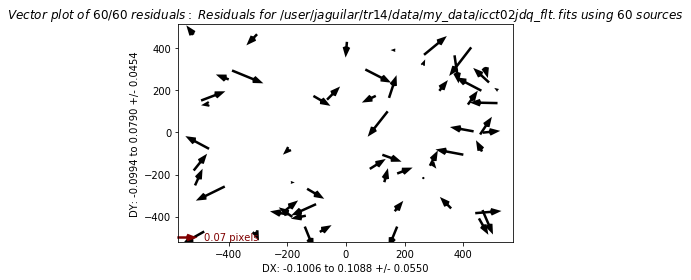

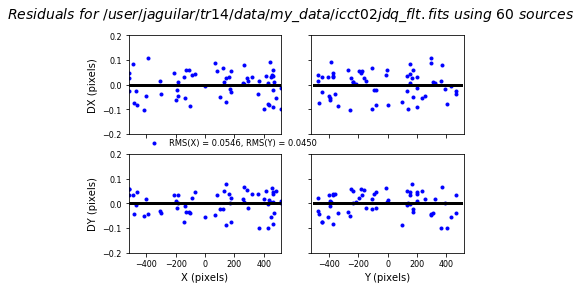

In [266]:
refcat = '../data/align_catalog/gaia.cat'
cw = 3.5  # Set to two times the FWHM of the PSF.
wcsname = 'Gaia'  # Specify the WCS name for this alignment
ff = list_of_images[:2]
thresh = 500.
tweakreg.TweakReg(ff,#'*flc.fits',  # Pass input images
                  updatehdr=False,  # update header with new WCS solution
                  imagefindcfg={'threshold':thresh,'conv_width':cw},  # Detection parameters, threshold varies for different data
                  refcat=refcat,  # Use user supplied catalog (Gaia)
                  interactive=False,
                  see2dplot=False,
                  shiftfile=True,  # Save out shift file (so we can look at shifts later)
                  outshifts='Gaia_shifts.txt',  # name of the shift file
                  wcsname=wcsname,  # Give our WCS a new name
                  reusename=True,
                  sigma=2.3,
                  ylimit=0.2,
                  fitgeometry='general')  # Use the 6 parameter fit
#%pdb 0
#%debug -b /Users/jaguilar/miniconda3/envs/orbitize/lib/python3.6/site-packages/drizzlepac/imgclasses.py:1604
# reload(tweakreg)
# tweakreg.TweakReg(list_of_images,
#                   refcat=refcat)

We can similarly look at the shift file from alignment to the Gaia catalog:

In [267]:
for line in open('Gaia_shifts.txt').readlines():
    print(line)

# frame: output

# refimage: shifts_wcs.fits[wcs]

# form: delta

# units: pixels

/user/jaguilar/tr14/data/my_data/icct02jfq_flt.fits    0.000000  0.000000    360.000000     1.000000   0.045278  0.044696

/user/jaguilar/tr14/data/my_data/icct02jdq_flt.fits    0.000000  0.000000    0.000000     1.000000   0.054568  0.045023



In [268]:
# Astrometric residual plots
# Image(filename='residuals_ibwb01xqq_flc.png',width=500, height=300)

In [269]:
# Image(filename='residuals_ibwb01xrq_flc.png',width=500, height=300)

In [270]:
# Image(filename='residuals_ibwb01xxq_flc.png',width=500, height=300)

As expected, the Gaia catalog does quite a bit better, with rms residuals less tha 0.05 pixels.  

To apply these transformations to the image, we simply need to run TweakReg the same as before, but set the parameter `updatehdr` equal to `True`:

Setting up logfile :  tweakreg.log
TweakReg Version 1.4.7(18-April-2018) started at: 01:21:31.631 (30/04/2020) 

Version Information
--------------------
Python Version [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 13:42:17) 
numpy Version -> 1.18.1 
astropy Version -> 4.0.1.post1 
stwcs Version -> 1.5.3 

Finding shifts for: 
    /user/jaguilar/tr14/data/my_data/icct02jfq_flt.fits
    /user/jaguilar/tr14/data/my_data/icct02jdq_flt.fits

===  Source finding for image '/user/jaguilar/tr14/data/my_data/icct02jfq_flt.fits':
  #  Source finding for '/user/jaguilar/tr14/data/my_data/icct02jfq_flt.fits', EXT=('SCI', 1) started at: 01:21:31.935 (30/04/2020)
     Found 63 objects.
===  FINAL number of objects in image '/user/jaguilar/tr14/data/my_data/icct02jfq_flt.fits': 63

===  Source finding for image '/user/jaguilar/tr14/data/my_data/icct02jdq_flt.fits':
  #  Source finding for '/user/jaguilar/tr14/data/my_data/icct02jdq_flt.fits

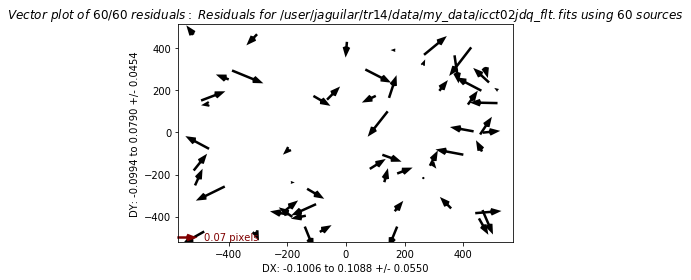

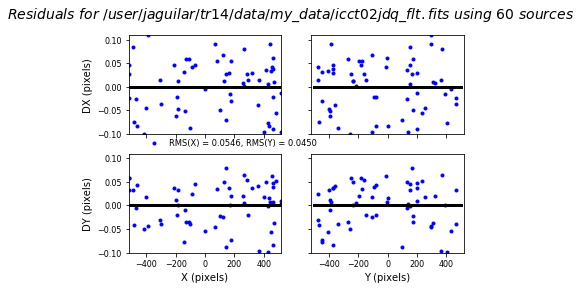

In [271]:
tweakreg.TweakReg(ff,  # Pass input images
                  updatehdr=True,  # update header with new WCS solution
                  imagefindcfg={'threshold': thresh, 'conv_width': cw},  # Detection parameters, threshold varies for different data
                  refcat=refcat,  # Use user supplied catalog (Gaia)
                  interactive=False,
                  see2dplot=False,
                  shiftfile=True,  # Save out shift file (so we can look at shifts later)
                  outshifts='Gaia_shifts.txt',  # name of the shift file
                  wcsname=wcsname,  # Give our WCS a new name
                  reusename=True,
                  sigma=2.3,
                  fitgeometry='general',  # Use the 6 parameter fit
                  clean=False,
                 )

## 4. Drizzle the Data

While the three sets of FLC files are now aligned, we drizzle together only the two long exposures. 

When exposures are very different lengths, drizzling them together doesn't work well when 'EXP' weighting is used. For objects that saturate in the long exposures, the problem occurs at the boundary where you transition from only short exposure to short plus long. Here the pixels getting power from long exposure pixels are only getting power from pixels whose centers are outside the ring, and thus they are weighted lower than they would be if they were getting values from both inside and outside the ring. The result is a discontinuity in the PSF radial profile and a resulting flux which is too low in those boundary pixels. For photometry of saturated objects, the short exposures should be drizzled separately from the long exposures. 

In [272]:
# Look at the catalog

In [274]:
cat_file = Path(f"./{Path(ff[0]).name.split('.')[0]}_catalog_fit.match")

In [275]:
cat_file.exists()

True

In [276]:
from utils import cat_utils
reload(cat_utils)

<module 'utils.cat_utils' from '/user/jaguilar/tr14/code/utils/cat_utils.py'>

In [277]:
cat_utils.cat_fit_columns

['x_ref',
 'y_ref',
 'x_input',
 'y_input',
 'x_fit',
 'y_fit',
 'x_resid',
 'y_resid',
 'x_orig_ref',
 'y_orig_ref',
 'x_orig_input',
 'y_orig_input',
 'ref_id',
 'input_id',
 'input_extver_id',
 'ra',
 'dec',
 'ref_source']

In [278]:
import pandas as pd

In [279]:
reload(cat_utils)

<module 'utils.cat_utils' from '/user/jaguilar/tr14/code/utils/cat_utils.py'>

In [280]:
master_catalog = pd.concat([cat_utils.catalog2pandas(f) 
                           for f in glob.glob("*catalog_fit.match")])
# make a unique index for each point source
master_catalog = master_catalog.reset_index(drop=True).reset_index()
master_catalog.rename(columns={'index':'sourceid'}, inplace=True)

/Users/jaguilar/miniconda3/envs/orbitize/lib/python3.6/site-packages/pandas/io/parsers.py:2420: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/Users/jaguilar/miniconda3/envs/orbitize/lib/python3.6/site-packages/pandas/io/parsers.py:2423: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


In [281]:
master_catalog.to_csv("../data/tables/master_fullframe_source_catalog.csv")

In [282]:
files = master_catalog['file_id'].unique()

In [283]:
files

array(['icct02jdq', 'icct02jfq'], dtype=object)

In [284]:
# example file
ff = files[0]
sub_catalog = master_catalog.query(f"file_id == '{ff}'")

In [285]:
hdulist = fits.open(glob.glob(f"../data/my_data/{ff}*fits")[0])
data = hdulist[1].data
hdulist.close()

./figs/tweakreg_demo_500.0.png


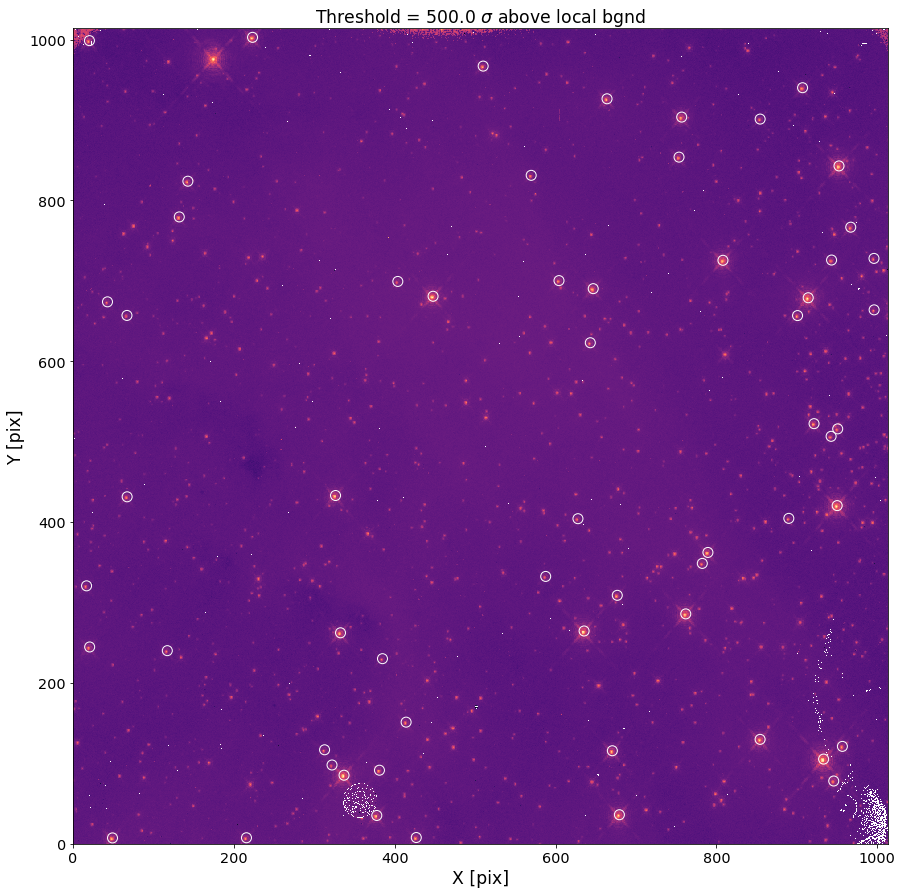

In [286]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
ax.imshow(data, origin='lower', norm=mpl.colors.LogNorm(), cmap=mpl.cm.magma)
ax.set_title(rf"Threshold = {thresh} $\sigma$ above local bgnd", size='xx-large')
ax.set_xlabel("X [pix]", size='xx-large')
ax.set_ylabel("Y [pix]", size='xx-large')
ax.tick_params(labelsize='x-large')
ax.scatter(sub_catalog['x_orig_input'], 
           sub_catalog['y_orig_input'], 
           marker='o', ec='w', fc='none', s=100)
ax.set_xlim(0, data.shape[1])
ax.set_ylim(0, data.shape[0])
# for i, row in sub_catalog.iterrows():
#     s = '{0:0.2f}, {1:0.2f}'.format(*row[['ra','dec']])
#     ax.annotate(s, row[['x_orig_input','y_orig_input']],
#                 fontsize='large',
#                 verticalalignment='top', horizontalalignment='center')
fname = f"./figs/tweakreg_demo_{thresh}.png"
print(fname)
if False:
    fig.savefig(fname, bbox_inches='tight')

In [287]:
sub_catalog['input_id'].unique().size

60

In [288]:
tab_html = master_catalog.to_html()

In [289]:
html = open("table.html", 'w')
html.write(tab_html)
html.close()

In [300]:
gb_fileid = master_catalog.groupby("file_id")

In [305]:
groups = list(gb_fileid.groups.keys())

In [308]:
print(gb_fileid.get_group(groups[0])['ref_id'].size)
print(gb_fileid.get_group(groups[1])['ref_id'].size)


60
58


In [328]:
for i in cat1.ref_id.unique():
    if i not in cat0.ref_id.unique():
        print(i)

1461
1076


In [310]:
cat0 = gb_fileid.get_group(groups[0])
cat1 = gb_fileid.get_group(groups[1])

In [323]:
np.sort(cat0.ref_id.unique())

array([  84,   99,  107,  133,  159,  174,  253,  254,  265,  288,  308,
        318,  322,  333,  354,  379,  402,  403,  439,  445,  530,  602,
        617,  622,  632,  634,  660,  663,  676,  682,  722,  735,  737,
        851,  885,  984, 1070, 1079, 1085, 1123, 1143, 1149, 1168, 1173,
       1221, 1257, 1274, 1278, 1523, 1607, 1651, 1653, 1665, 1681, 1735,
       1788, 1802, 1814, 1866, 2085])

In [324]:
np.sort(cat1.ref_id.unique())

array([  84,   99,  107,  133,  159,  174,  253,  265,  288,  308,  318,
        322,  333,  354,  379,  402,  403,  439,  445,  530,  602,  617,
        622,  632,  634,  663,  676,  682,  722,  735,  737,  851,  885,
        984, 1070, 1076, 1079, 1085, 1123, 1143, 1149, 1168, 1173, 1221,
       1257, 1278, 1461, 1523, 1607, 1651, 1653, 1665, 1681, 1788, 1802,
       1814, 1866, 2085])

In [331]:
pd.DataFrame.to_hdf?

Signature:
pd.DataFrame.to_hdf(
    self,
    path_or_buf,
    key:str,
    mode:str='a',
    complevel:Union[int, NoneType]=None,
    complib:Union[str, NoneType]=None,
    append:bool=False,
    format:Union[str, NoneType]=None,
    index:bool=True,
    min_itemsize:Union[int, Dict[str, int], NoneType]=None,
    nan_rep=None,
    dropna:Union[bool, NoneType]=None,
    data_columns:Union[List[str], NoneType]=None,
    errors:str='strict',
    encoding:str='UTF-8',
) -> None
Docstring:
Write the contained data to an HDF5 file using HDFStore.

Hierarchical Data Format (HDF) is self-describing, allowing an
application to interpret the structure and contents of a file with
no outside information. One HDF file can hold a mix of related objects
which can be accessed as a group or as individual objects.

In order to add another DataFrame or Series to an existing HDF file
please use append mode and a different a key.

For more information see the :ref:`user guide <io.hdf5>`.

Parameters
-----

In [333]:
import h5py

In [336]:
f = h5py.File("../data/tables/test.hdf5", 'w')

In [339]:
f.keys()

<KeysViewHDF5 []>

In [342]:
prihdrs.to_hdf('./test.hdf5', key='table')

/Users/jaguilar/miniconda3/envs/orbitize/lib/python3.6/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['origin', 'date', 'filename', 'filetype', 'telescop', 'instrume',
       'rootname', 'imagetyp', 'primesi', 'targname', 'pr_inv_l', 'pr_inv_f',
       'pr_inv_m', 'fgslock', 'gyromode', 'refframe', 'date-obs', 'time-obs',
       'expflag', 'opus_ver', 'csys_ver', 'cal_ver', 'obstype', 'obsmode',
       'sclamp', 'subtype', 'detector', 'filter', 'samp_seq', 'aperture',
       'dirimage', 'saa_exit', 'scan_typ', 'scan_cor', 'csmid', 'dqicorr',
       'zsigcorr', 'zoffcorr', 'darkcorr', 'blevcorr', 'nlincorr', 'flatcorr',
       'crcorr', 'unitcorr', 'photcorr', 'rptcorr', 'drizcorr', 'bpixtab',
       'ccdtab', 'oscntab', 'crrejtab', 'darkfile', 'nlinfile', 'pfltfile',
       'imphttab', 'mdriztab', 'photmode', '

In [345]:
open?

Signature:
open(
    file,
    mode='r',
    buffering=-1,
    encoding=None,
    errors=None,
    newline=None,
    closefd=True,
    opener=None,
)
Docstring:
Open file and return a stream.  Raise IOError upon failure.

file is either a text or byte string giving the name (and the path
if the file isn't in the current working directory) of the file to
be opened or an integer file descriptor of the file to be
wrapped. (If a file descriptor is given, it is closed when the
returned I/O object is closed, unless closefd is set to False.)

mode is an optional string that specifies the mode in which the file
is opened. It defaults to 'r' which means open for reading in text
mode.  Other common values are 'w' for writing (truncating the file if
it already exists), 'x' for creating and writing to a new file, and
'a' for appending (which on some Unix systems, means that all writes
append to the end of the file regardless of the current seek position).
In text mode, if encoding is not specified

In [351]:
ff = Path(f.filename)
